### Generate the estimated gravitational waveform and calculate the signal-to-noise for GW151226 ###

In [2]:
# Get the data for H1 from the LOSC site
!curl -O -J https://losc.ligo.org/s/events/GW151226/H-H1_LOSC_4_V2-1135136334-32.gwf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1004k  100 1004k    0     0  1781k      0 --:--:-- --:--:-- --:--:-- 1781k


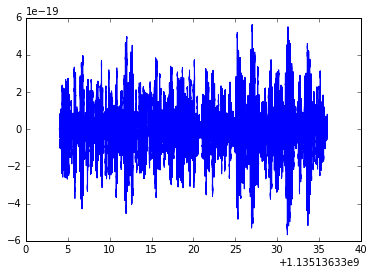

In [3]:
%matplotlib inline
import pylab
# Import the functions we need for later!
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_td_waveform, taper_timeseries
from pycbc.psd import welch, interpolate

# Read the Hanford data and remove low frequency content
h1 = read_frame('H-H1_LOSC_4_V2-1135136334-32.gwf', 'H1:LOSC-STRAIN')
h1 = highpass_fir(h1, 15, 16)

# Can you spot where the signal is beforehand?
pylab.plot(h1.sample_times, h1)

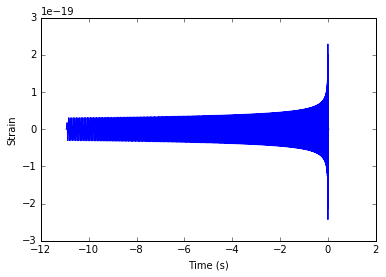

In [4]:
# Generate a waveform similar to LVT151012
# Make a template from the public parameters from the LOSC and filter 
# the data to get the phase difference.
z = 0.09
m1 = 14.2 * (1 + z) 
m2 = 7.5 * (1 + z)
s1 = s2 = 0.2

# The frequency to start generating the waveform
fstart = 15.0
hp, hc = get_td_waveform(approximant="SEOBNRv2",
                         mass1=m1, mass2=m2, spin1z=s1, spin2z=s2,
                         f_lower=fstart,
                         delta_t=h1.delta_t)
hp = taper_timeseries(hp, tapermethod='start')

# Move the waveform so that the merge is about at the end
# This means that an SNR spike later on in the data lines up with this point
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

hp.resize(len(h1))
hp.roll(int(hp.start_time * hp.sample_rate))

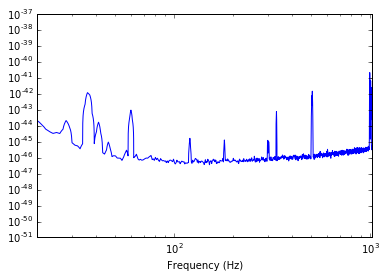

In [5]:
# Estimate the noise spectrum
# Normally we use more data to estimate the psd, but this is illustrative
psd = interpolate(welch(h1), 1.0 / h1.duration)

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(20, 1024)
pylab.xlabel('Frequency (Hz)')

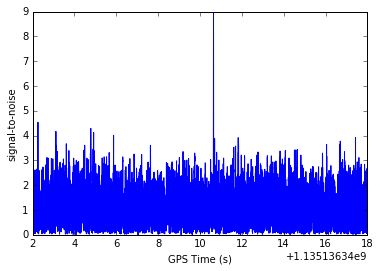

In [6]:
# Calculate the complex Signal-to-noise. This is a complex vector
# because the signal could have any phase.
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=30.0)

# Remove regions corrupted by filter wraparound
snr = snr[len(snr) / 4: len(snr) * 3 / 4]

# Now you should be able to spot where the signal is!
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  989k  100  989k    0     0  1700k      0 --:--:-- --:--:-- --:--:-- 1703k


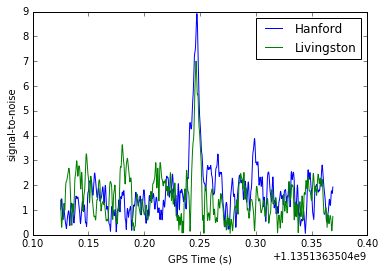

In [7]:
# Now let's see what the SNR timeseries looks like in the other detector in Livingston.
# Get the data for H1 from the LOSC site
!curl -O -J https://losc.ligo.org/s/events/GW151226/L-L1_LOSC_4_V2-1135136334-32.gwf

# Read the Hanford data and remove low frequency content
l1 = read_frame('L-L1_LOSC_4_V2-1135136334-32.gwf', 'L1:LOSC-STRAIN')
l1 = highpass_fir(l1, 15, 16)
l1_psd = interpolate(welch(l1), 1.0 / l1.duration)
l1_snr = matched_filter(hp, l1, psd=l1_psd, low_frequency_cutoff=30.0)
l1_snr = l1_snr[len(l1_snr) / 4: len(l1_snr)* 3 / 4]

# Let's look closer around the H1 peak
i = snr.abs_arg_max()
snr = snr[i-500:i+500]
l1_snr = l1_snr[i-500:i+500]

# There is a SNR peak near the same time!
pylab.plot(snr.sample_times, abs(snr), label='Hanford')
pylab.plot(l1_snr.sample_times, abs(l1_snr), label='Livingston')
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()